In [44]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [48]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vals)
#print(eigen_vecs)

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


In [54]:
# taking just first 2 eigen vectors but we could take as many as we want our k to be
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], 
               eigen_pairs[1][1][:, np.newaxis]))

X_train_pca_manual = X_train_std.dot(w)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)
lr.fit(X_train_pca, y_train)
print(lr.coef_)

lr.fit(X_train_pca_manual, y_train)
print(lr.coef_)

[[ 1.59954057 -1.44963046]
 [ 0.06658775  2.90262559]
 [-1.51638726 -1.57383394]]
[[ 1.59954057  1.44963046]
 [ 0.06658775 -2.90262559]
 [-1.51638726  1.57383394]]


In [56]:
# LDA also needs std data
np.set_printoptions(precision=4)
mean_vecs = []

for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('{}: {}'.format(label, mean_vecs[label-1]))

1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]
2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]
3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]


In [60]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
#    class_scatter = np.zeros((d, d))
#    for row in X_train[y_train==label]:
 #       row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        #class_scatter += (row - mv).dot((row-mv).T) # if class labels are not uniform, scale here -> np.cov
    class_scatter += np.cov(X_train[y_train==label].T)   
    S_W += class_scatter

print('Within-class scatter: {}'.format(S_W))

Within-class scatter: [[  1.7635e+04   3.4151e+03   2.8949e+03   2.8533e+04   1.3593e+05
    3.5946e+03   2.7261e+03  -3.9093e+02   2.6202e+03   8.6361e+03
    2.5164e+03   4.0359e+03   8.5188e+05]
 [  3.4151e+03   8.0006e+02   5.6195e+02   5.5669e+03   2.6038e+04
    6.9089e+02   5.1890e+02  -7.2502e+01   4.9982e+02   1.6469e+03
    4.8755e+02   7.8412e+02   1.6572e+05]
 [  2.8949e+03   5.6195e+02   4.7935e+02   4.7219e+03   2.2362e+04
    5.9264e+02   4.4854e+02  -6.4206e+01   4.2905e+02   1.4106e+03
    4.1415e+02   6.6444e+02   1.3949e+05]
 [  2.8533e+04   5.5669e+03   4.7219e+03   4.6810e+04   2.2057e+05
    5.8388e+03   4.4250e+03  -6.3332e+02   4.2345e+03   1.3904e+04
    4.0813e+03   6.5408e+03   1.3766e+06]
 [  1.3593e+05   2.6038e+04   2.2362e+04   2.2057e+05   1.0629e+06
    2.7680e+04   2.1211e+04  -3.0944e+03   2.0219e+04   6.6355e+04
    1.9426e+04   3.1046e+04   6.5964e+06]
 [  3.5946e+03   6.9089e+02   5.9264e+02   5.8388e+03   2.7680e+04
    7.4303e+02   5.5718e+02  -7

In [59]:
print('Class label distribution: {}'.format(np.bincount(y_train)[1:])) # should be uniform, otherwise we need to scale

Class label distribution: [40 49 35]


In [62]:
# between classes scatter 

mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    
S_B = n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between class scatter: {}'.format(S_B))


Between class scatter: [[  9.3793e-01   5.1159e+00   1.8614e+00   3.2416e+00  -5.7237e-02
   -5.4424e+00  -7.0357e+00   4.2606e+00  -4.3843e+00   5.6092e+00
   -6.7023e+00  -7.4525e+00  -2.2414e+00]
 [  5.1159e+00   2.7905e+01   1.0153e+01   1.7681e+01  -3.1220e-01
   -2.9686e+01  -3.8376e+01   2.3240e+01  -2.3914e+01   3.0596e+01
   -3.6558e+01  -4.0649e+01  -1.2226e+01]
 [  1.8614e+00   1.0153e+01   3.6941e+00   6.4333e+00  -1.1359e-01
   -1.0801e+01  -1.3963e+01   8.4556e+00  -8.7010e+00   1.1132e+01
   -1.3301e+01  -1.4790e+01  -4.4483e+00]
 [  3.2416e+00   1.7681e+01   6.4333e+00   1.1204e+01  -1.9782e-01
   -1.8810e+01  -2.4317e+01   1.4725e+01  -1.5153e+01   1.9386e+01
   -2.3164e+01  -2.5757e+01  -7.7466e+00]
 [ -5.7237e-02  -3.1220e-01  -1.1359e-01  -1.9782e-01   3.4929e-03
    3.3212e-01   4.2936e-01  -2.6001e-01   2.6755e-01  -3.4230e-01
    4.0901e-01   4.5479e-01   1.3678e-01]
 [ -5.4424e+00  -2.9686e+01  -1.0801e+01  -1.8810e+01   3.3212e-01
    3.1580e+01   4.0825e+01  -

In [65]:
eigen_vals, eigen_vecs = np.linalg.eigh(np.linalg.inv(S_W).dot(S_B))
print(eigen_vals)

[ -1.0334e+02  -3.3367e+01  -9.5279e+00  -1.2263e-01   2.9037e-04
   1.1935e-01   6.1188e-01   1.3689e+00   5.8031e+00   1.0138e+01
   1.1845e+01   4.2635e+01   1.8747e+02]


In [67]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
               
# taking just first 2 eigen vectors but we could take as many as we want our k to be
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], 
               eigen_pairs[1][1][:, np.newaxis]))

X_train_lda_manual = X_train_std.dot(w)

In [69]:
from sklearn.lda import LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
print(lr.coef_)

lr.fit(X_train_pca_manual, y_train)
print(lr.coef_)

[[-1.4255  1.5279]
 [ 0.0343 -2.6257]
 [ 1.189   1.2346]]
[[ 1.5995  1.4496]
 [ 0.0666 -2.9026]
 [-1.5164  1.5738]]


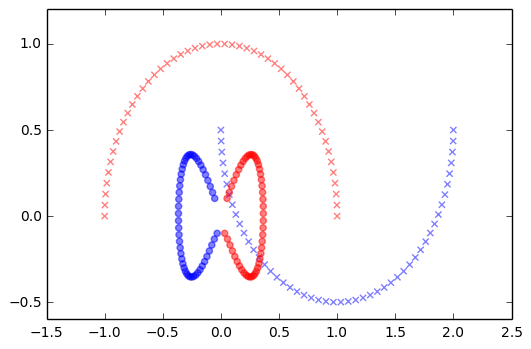

In [74]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=1)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)


plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='x', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='x', alpha=0.5)

plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.5)
